In [1]:
import numpy as np
import pandas as pd #to work with csv files

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words
#pre-processing of text
import string
import re
from gensim.models import Word2Vec, KeyedVectors
import gensim
import gensim.downloader as gensim_api
#import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

#import time function from time module to track the training duration
from time import time
from collections import OrderedDict

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import OrderedDict

In [2]:
imdb = pd.read_csv('IMDB_Dataset.csv')

In [3]:
imdb.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [4]:
def clean_text(str_list, lemmatize = True):
    clean_list = []
    
    for text in str_list:
        # to drop html tags
        text = re.sub(r'<br /><br />', '', text)
        words = word_tokenize(text)
        clean_words = []
        
        for word in words:            
            # drop words with fewer than 2 characters; drop any punctuation "words"
            if (len(word) > 1) and (re.match(r'^\w+$', word)):

                if lemmatize==True:
                    lemmatizer=WordNetLemmatizer()
                    word1 = lemmatizer.lemmatize(word)
                    #if word!=word1:
                        #print(word1)
                        #print(word)
                    
                clean_words.append(word1)
        clean_text = ' '.join(clean_words)
        clean_list.append(clean_text)
    
    return clean_list

In [5]:
# run on all reviews
imdb['clean_review'] = clean_text(imdb['review'])

In [6]:
imdb.head()

review sentiment   
0  One of the other reviewers has mentioned that ...  positive  \
1  A wonderful little production. <br /><br />The...  positive   
2  I thought this was a wonderful way to spend ti...  positive   
3  Basically there's a family where a little boy ...  negative   
4  Petter Mattei's "Love in the Time of Money" is...  positive   

                                        clean_review  
0  One of the other reviewer ha mentioned that af...  
1  wonderful little production The filming techni...  
2  thought this wa wonderful way to spend time on...  
3  Basically there family where little boy Jake t...  
4  Petter Mattei Love in the Time of Money is vis...

In [7]:
imdb['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [8]:
imdb['sentiment'] = imdb['sentiment'].map(lambda x : 1 if x == 'positive' else 0)
imdb['sentiment']

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

In [9]:
imdb['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [10]:
#Step 1: train-test split
X = imdb['review'] #the column text contains textual data to extract features from
y = imdb['sentiment'] #this is the column we are learning to predict. 

print(X.shape, y.shape)

#random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000,) (50000,)
(45000,) (45000,)
(5000,) (5000,)


In [11]:
#Train a classifier
vect = TfidfVectorizer(lowercase = True,
                        stop_words = 'english',
                        ngram_range = (1,1)) #instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LogisticRegression(penalty="l2", C=0.1) #instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

Accuracy:  0.8702


In [12]:
# select any review from the test set
index = 11
mystring = imdb.iloc[index,2]
mystring

'saw this movie when wa about 12 when it came out recall the scariest scene wa the big bird eating men dangling helplessly from parachute right out of the air The horror The young kid going to these cheesy film on Saturday afternoon still wa tired of the formula for these monster type movie that usually included the hero beautiful woman who might be the daughter of professor and happy resolution when the monster died in the end did care much for the romantic angle a 12 year old and the predictable plot love them now for the unintentional about year or so later saw Psycho when it came out and loved that the star Janet Leigh wa bumped off early in the film sat up and took notice at that point Since screenwriter are making up the story make it up to be a scary a possible and not from formula There are no rule'

In [16]:
mystring = 'The movie was a true masterpiece, captivating from start to finish with its brilliant storytelling, exceptional performances, and stunning cinematography that left me in awe.'

In [17]:
# Get the actual class of the tweet selected in the test set
true_class = imdb.iloc[index,1]
true_class

0

In [18]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

y_pred_prob = classifier.predict_proba(X_test_dtm)[:, 1]
c = make_pipeline(vect, classifier)
# mystring = list(X_test)[1] #Take a string from test instance
print(c.predict_proba([mystring]))
# actual = lambda x : 'unreliable' if x else 'reliable'
print(c.predict([mystring]))

print("Probability (positive) =", c.predict_proba([mystring])[0, 1])
print("Probability (negative) =", c.predict_proba([mystring])[0, 0])
print("True Class is:", true_class)

[[0.1716975 0.8283025]]
[1]
Probability (positive) = 0.828302500016825
Probability (negative) = 0.17169749998317496
True Class is: 0


In [19]:
c.predict_proba

<bound method Pipeline.predict_proba of Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression(C=0.1))])>

In [20]:
c = make_pipeline(vect, classifier)

# Initialize LimeTextExplainer
explainer = LimeTextExplainer(class_names=["negative", "positive"])

# Generate explanation for the prediction
exp = explainer.explain_instance(mystring, c.predict_proba, num_features=6)

# Show explanation
# This will display a matplotlib plot that helps you interpret the model's prediction.
exp.show_in_notebook()

In [21]:
pwd

'C:\\Users\\Sunday Okechukwu\\Documents'

In [22]:
# Alternatively, you can get a list form of the explanation
# This will give you a list of tuples ('feature', 'explanation weight')
print(exp.as_list())

[('brilliant', 0.08443622460513132), ('performances', 0.04589837728224779), ('left', -0.04446601311406713), ('masterpiece', 0.04359942334296571), ('true', 0.04196558868118836), ('stunning', 0.024908227509943058)]


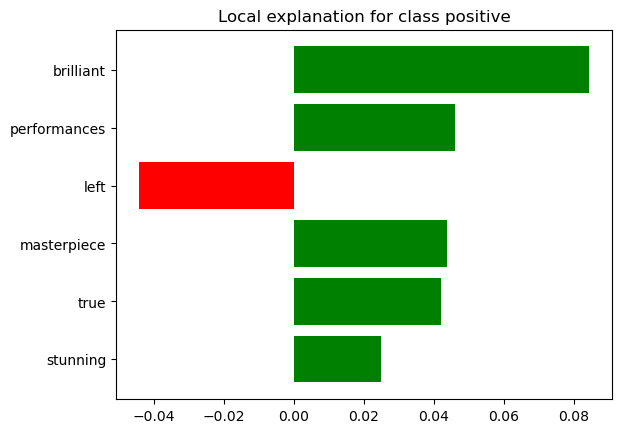

In [23]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [24]:
exp.show_in_notebook(text=mystring, labels=(1,))

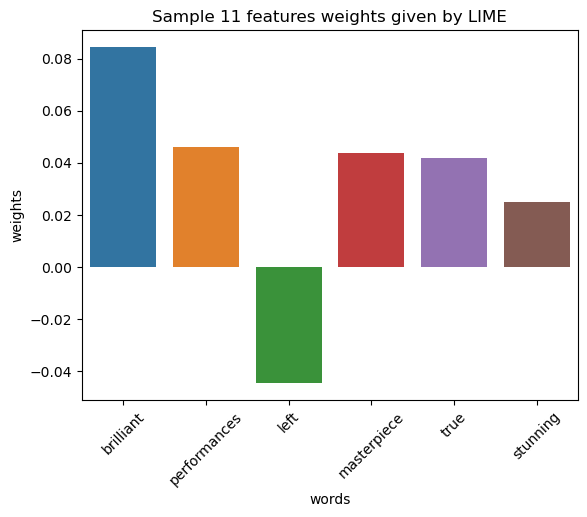

In [25]:
weights = OrderedDict(exp.as_list())
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 45)
plt.title("Sample {} features weights given by LIME".format(index))
plt.show()

In [26]:
import shap

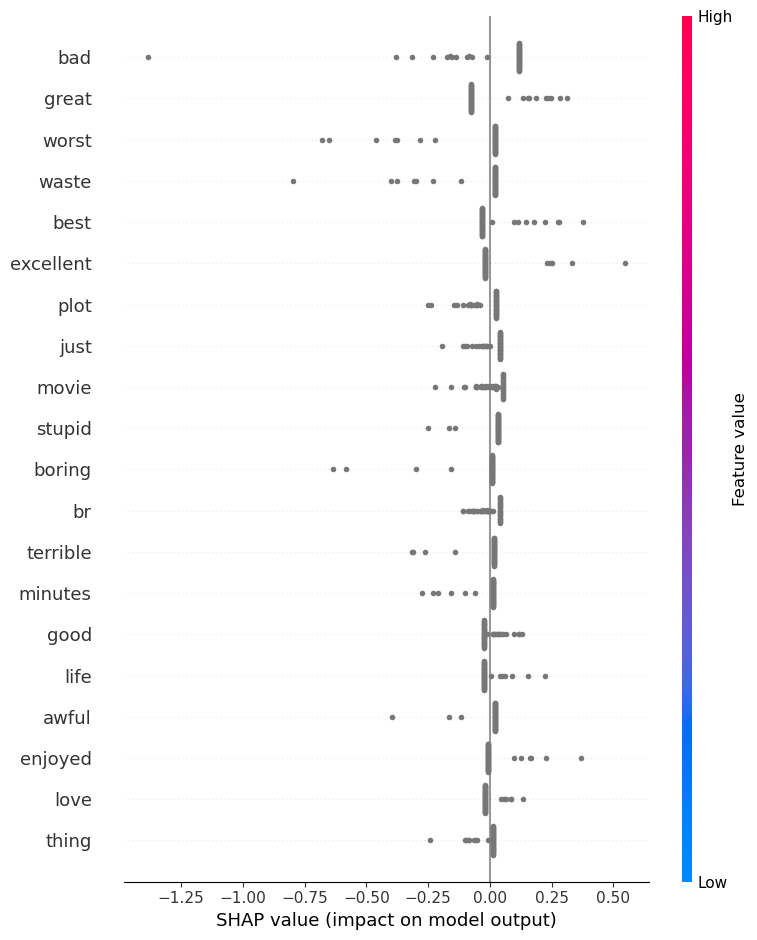

In [27]:
# Instantiate explainer object
explainer = shap.LinearExplainer(classifier, X_train_dtm, feature_names=vect.get_feature_names_out())

# Generate SHAP values
shap_values = explainer.shap_values(X_test_dtm[:50])

# Plotting
shap.summary_plot(shap_values, X_test_dtm[:50], feature_names=vect.get_feature_names_out())


In [28]:
explainer = shap.LinearExplainer(classifier,
                                 X_train_dtm,
                                 feature_dependence="independent")

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [29]:
shap_values = explainer.shap_values(X_test_dtm[:100])
shap_values[0]

array([ 1.63446722e-05,  2.24977287e-04, -0.00000000e+00, ...,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00])

In [90]:
# print(shap_values.shape)
# print(X_test_array.shape)
# print(len(vect.get_feature_names_out()))


In [ ]:
print(np.shape(shap_values))


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


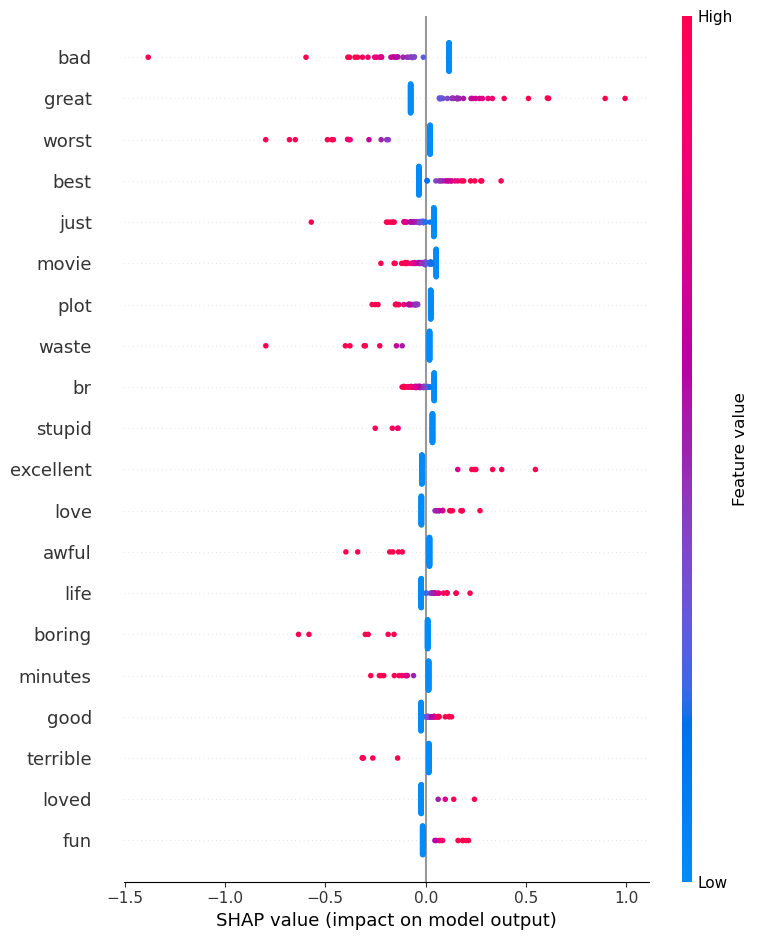

In [31]:
X_test_array = X_test_dtm[:100].toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=vect.get_feature_names_out())

In [32]:
# Initialization for JavaScript plots
shap.initjs()

# Calculate SHAP values for the first review
shap_values_single = explainer.shap_values(X_test_dtm[4])

# Create a force plot for the first review
shap.force_plot(explainer.expected_value, shap_values_single[0], feature_names=vect.get_feature_names_out())


In [33]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
import os
import tensorflow as tf

In [34]:
import os
import shutil

# Original directory paths for cats, dogs
cats_dir = os.path.join('./animals/cats/')
dogs_dir = os.path.join('./animals/dogs/')
# pandas_dir = os.path.join('./animals/panda/')

# Destination directory
dest_dir = os.path.join('./animals/cats_dogs_combined/')

# Create destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Function to copy files
def copy_files(src_dir, dest_dir):
    for filename in os.listdir(src_dir):
        shutil.copy(os.path.join(src_dir, filename), os.path.join(dest_dir, filename))

# Copy files
copy_files(cats_dir, dest_dir)
copy_files(dogs_dir, dest_dir)
# copy_files(pandas_dir, dest_dir)


In [35]:
import pandas as pd

filenames = os.listdir("./animals/cats_dogs_combined/")

categories = []
for f_name in filenames:
    category = f_name.split('_')[0]  # Get the prefix to identify the category
    categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [36]:
df

filename category
0     cats_00001.jpg     cats
1     cats_00002.jpg     cats
2     cats_00003.jpg     cats
3     cats_00004.jpg     cats
4     cats_00005.jpg     cats
...              ...      ...
1995  dogs_00996.jpg     dogs
1996  dogs_00997.jpg     dogs
1997  dogs_00998.jpg     dogs
1998  dogs_00999.jpg     dogs
1999  dogs_01000.jpg     dogs

[2000 rows x 2 columns]

In [37]:
# Path to train and test directory
dir_ = './animals/cats_dogs_combined/'

In [38]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,test_df = train_test_split(df,test_size=0.10,
  random_state=42)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_test=test_df.shape[0]


In [39]:
total_train

1800

In [40]:
total_test

200

In [41]:
pwd

'C:\\Users\\Sunday Okechukwu\\Documents'

In [42]:
# Generate training and test data with Image Generator

dir_ = 'C:\\Users\\Sunday Okechukwu\\Documents\\animals'

train_datagen = ImageDataGenerator(rescale=1/255,
                                  validation_split=0.2)

train_generator = train_datagen.flow_from_directory(dir_,
                                                    target_size=(100, 100),
                                                    batch_size=1920,
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    subset='training')

test_generator = train_datagen.flow_from_directory(dir_,
                                                   target_size=(100, 100),
                                                   batch_size=480,
                                                   class_mode='categorical',
                                                   shuffle=False,
                                                   subset='validation')


Found 3200 images belonging to 3 classes.
Found 800 images belonging to 3 classes.


In [43]:
import os

print(os.path.exists(dir_))  # Should print True
print(os.listdir(dir_))  # Should list sub-folders ['cats', 'dogs', 'panda']


True
['cats', 'cats_dogs_combined', 'dogs']


In [44]:
model = Sequential([
    
    # First convolution
        Conv2D(16, (3,3), activation='relu', input_shape=(100, 100, 3)),
        MaxPooling2D(2, 2),
    
    # Second convolution
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
    # Third convolution
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
        Flatten(),
    
    # Dense hidden layer
        Dense(512, activation='relu'),
        Dropout(0.2),
    
    # Output neuron. 
        Dense(3, activation='softmax')

])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
      train_generator,  
      epochs=80,
      verbose=1)

In [ ]:
model.save('my_model.h5')

In [47]:
from keras.models import load_model

In [48]:
loaded_model = load_model('my_model.h5')

In [49]:
from skimage import io

In [50]:
pwd

'C:\\Users\\Sunday Okechukwu\\Documents'

In [51]:
test_df.sample(1)

filename category
144  dogs_00567.jpg     dogs

In [52]:
import numpy as np
from skimage import io
from skimage.transform import resize
from tensorflow.keras.preprocessing import image

# Make sure you've defined or loaded 'model' before running this code.

url = './animals/dogs/dogs_00191.jpg'

def read_and_transform_img(url):
    img = io.imread(url)
    img = resize(img, (100, 100))  # Using the imported resize function directly
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Using numpy which is imported as np
    
    return img

images = read_and_transform_img(url)

# Make sure the 'model' is defined or loaded before this line
preds = model.predict(images)
prediction = np.argmax(preds)  # Using numpy which is imported as np
pct = np.max(preds)  # Using numpy which is imported as np

if prediction == 0:
    print('It\'s a cat!')
else:
    print('It\'s a dog!')

print(pct)


1/1 [==============================] - 1s 603ms/step
It's a dog!
0.3753088


In [53]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
# Your code to explain an instance
explanation = explainer.explain_instance(images[0].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


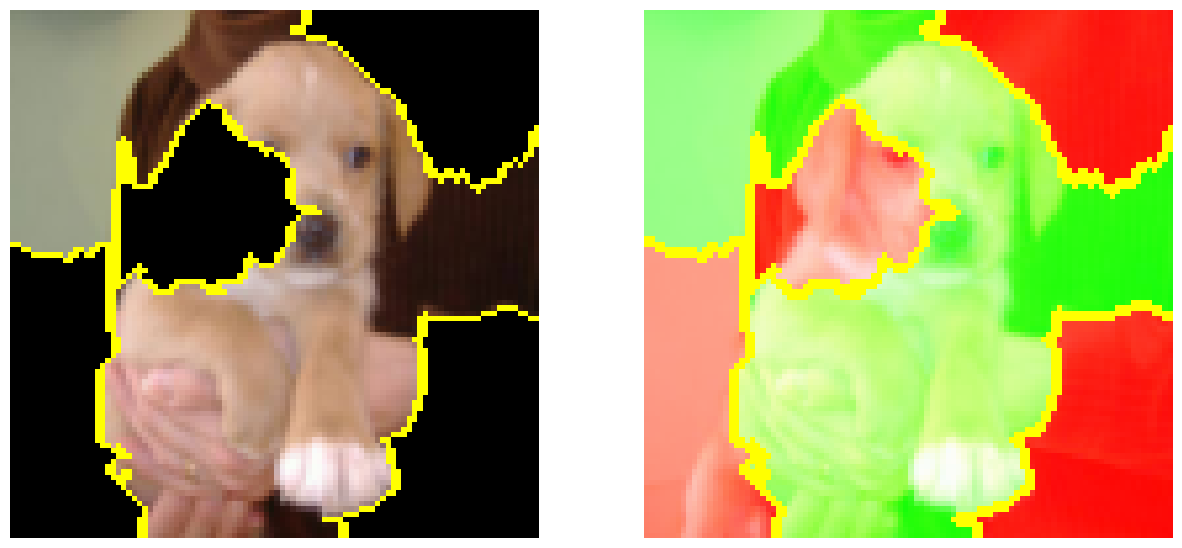

In [54]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Assuming you have already generated an 'explanation' object from LIME
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

# Save the visualization to PDF
plt.savefig("Table3-4.pdf", format="pdf", bbox_inches="tight")

plt.show()


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


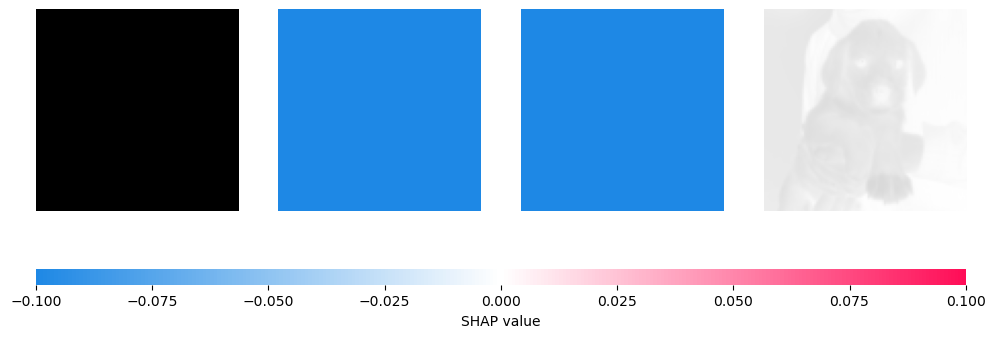

In [55]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

expanded_images = np.expand_dims(images[0], axis=0)  # Now the shape will be (1, 100, 100, 3)

# Initialize the explainer. DeepExplainer is specifically suited for deep learning models
# Initialize the explainer
explainer = shap.DeepExplainer(model, expanded_images)

# Compute SHAP values
shap_values = explainer.shap_values(expanded_images)

# SHAP plot
shap.image_plot(shap_values, -expanded_images)




2/2 [==============================] - 0s 22ms/step


  0%|          | 0/498 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


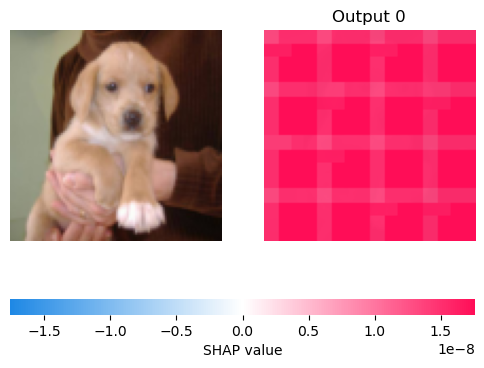

In [56]:
import shap

# Your previously defined model and expanded_images
# model = ...
# expanded_images = ...

# Wrap the model so that it can take raw (non-preprocessed) input images
def f(X):
    tmp = X.copy()
    tmp = preprocess_input(tmp)
    return model.predict(tmp)

# Define a masker that is used to mask out partitions of the input image
# This one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", expanded_images[0].shape)

# Initialize the explainer
explainer = shap.Explainer(f, masker)

# Estimate the SHAP values
shap_values = explainer(expanded_images, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])

shap.image_plot(shap_values)

## Neural Networks and Deep Learning

#### Interpreting what CNNs learn

A fundamental problem when building a computer vision application is that of interpretability: why did your classifier think a particular image contained a fridge, when all you can see is a truck?

It is often said that deep learning models are "black boxes": they learn representations that are difficult to extract and present in a human-readable form. Although this is partially true for certain types of deep learning models, it is definitely not true for CNNs. The representations learned by CNNs are highly amenable to visualization, in large part because they are representations of visual concepts. Since 2013, a wide array of techniques has been developed for visualizing and interpreting these representations.

- **Visualizing intermediate CNN outputs (intermediate activations)**: Useful for understanding how successive CNN layers transform their input, and for getting a first idea of the meaning of individual CNN filters

- **Visualizing CNN filters**: Useful for understanding precisely what visual pattern or concept each filter in a CNN is receptive to

- **Visualizing heat-maps of class activation in an image**: Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images

## Visualizing intermediate activations

- Visualizing intermediate activations consists of displaying the values returned by various convolution and pooling layers in a model, given a certain input (the output of a layer is often called its activation,the output of the activation function).
- This gives a view into how an input is decomposed into the different filters learned by the network.
- We want to visualize feature maps with three dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

In [57]:
from tensorflow import keras
model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

#### Preprocessing a single image

In [58]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

#### Displaying the test picture

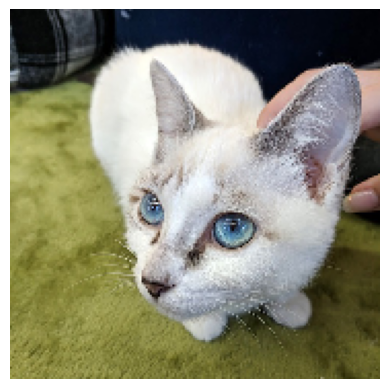

In [59]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

#### Instantiating a model that returns layer activations

In [60]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

#### Using the model to compute layer activations

In [61]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 118ms/step


In [62]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


#### Visualizing the fifth channel

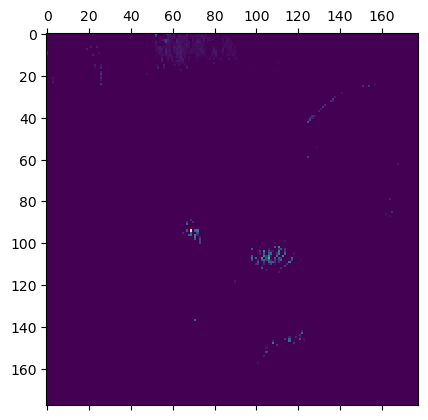

In [63]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

#### Visualizing every channel in every intermediate activation

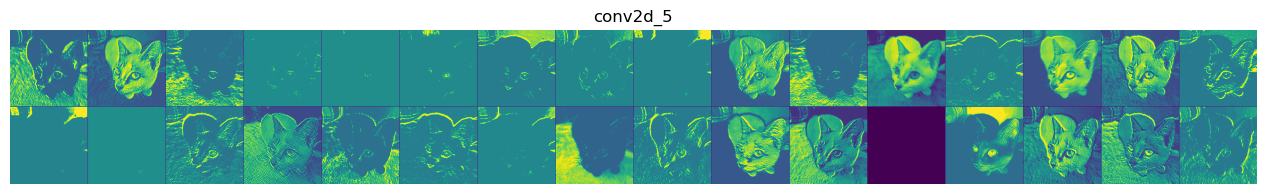

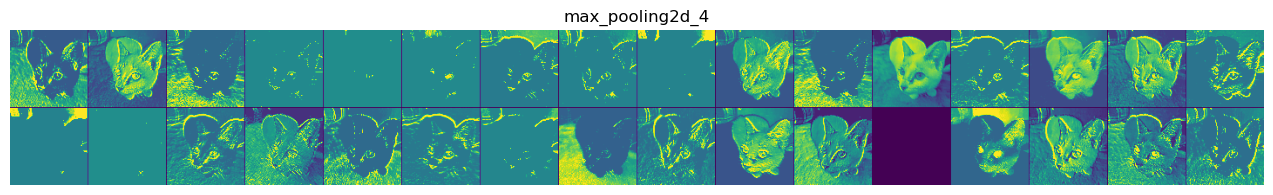

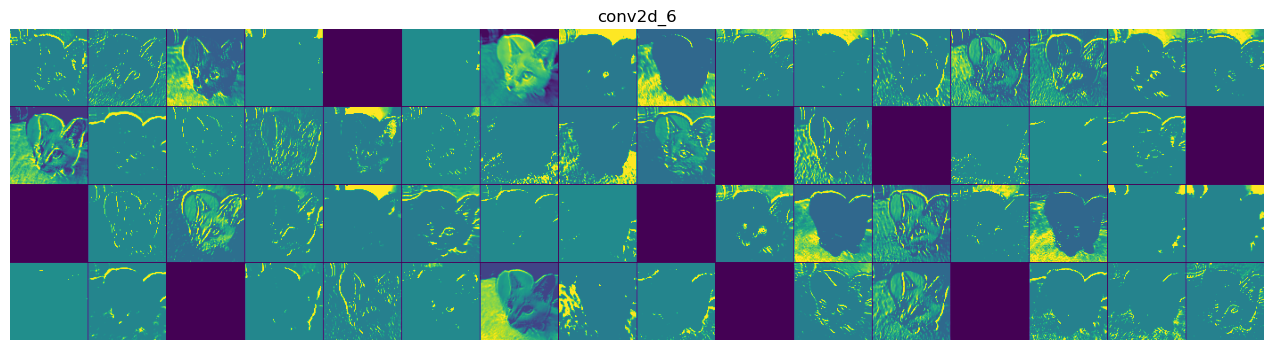

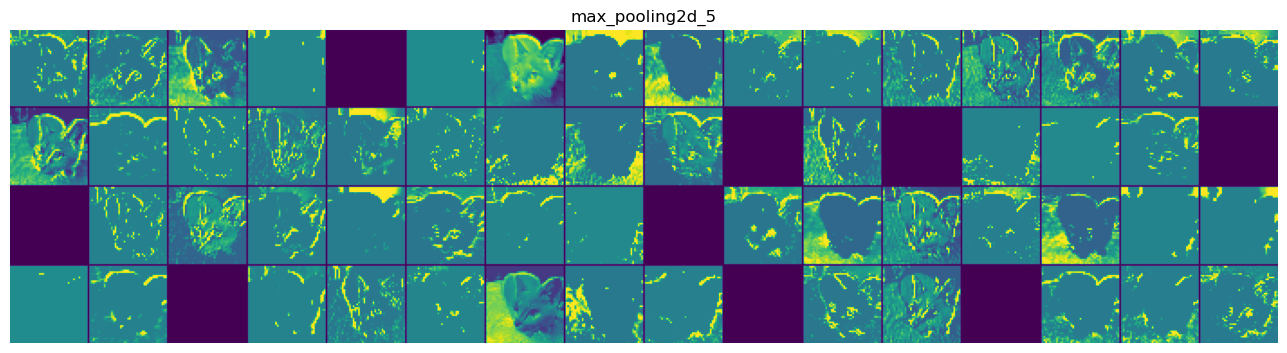

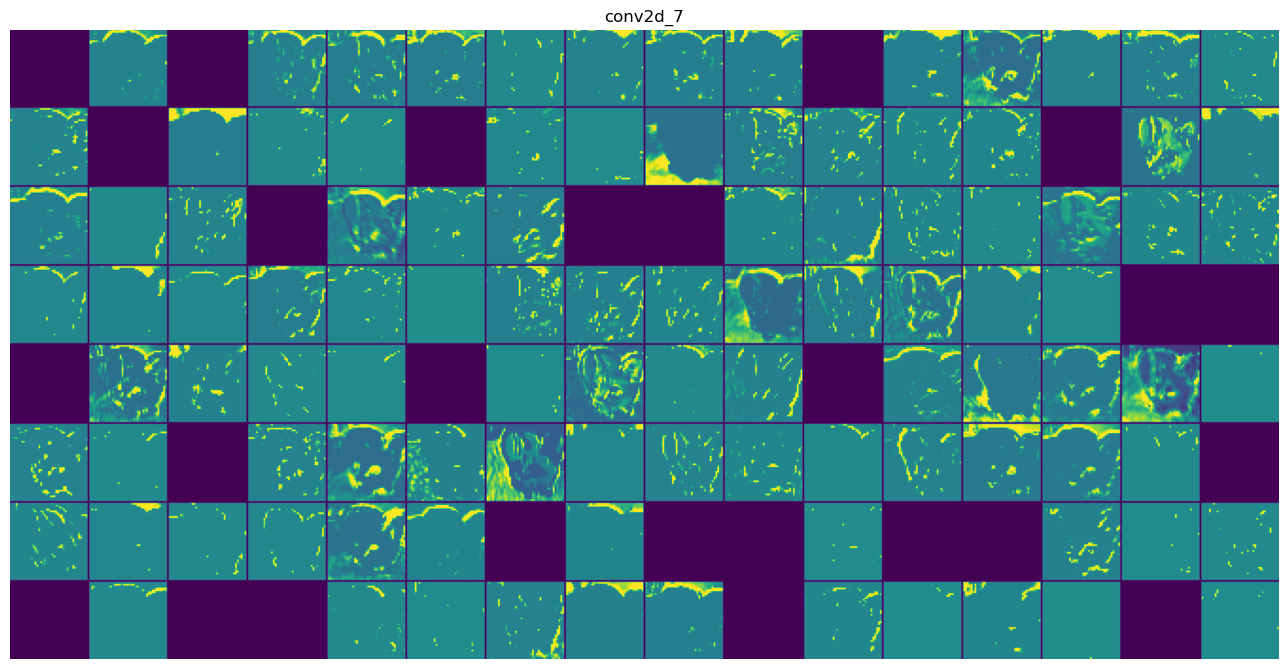

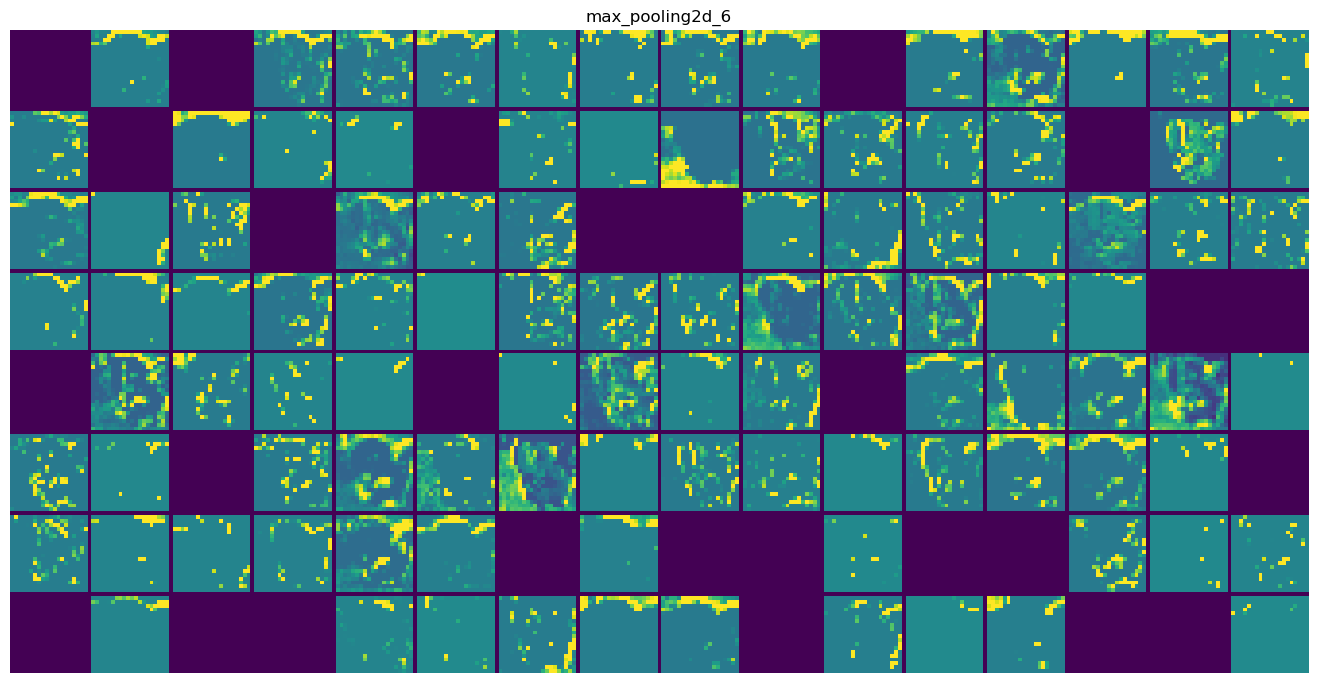

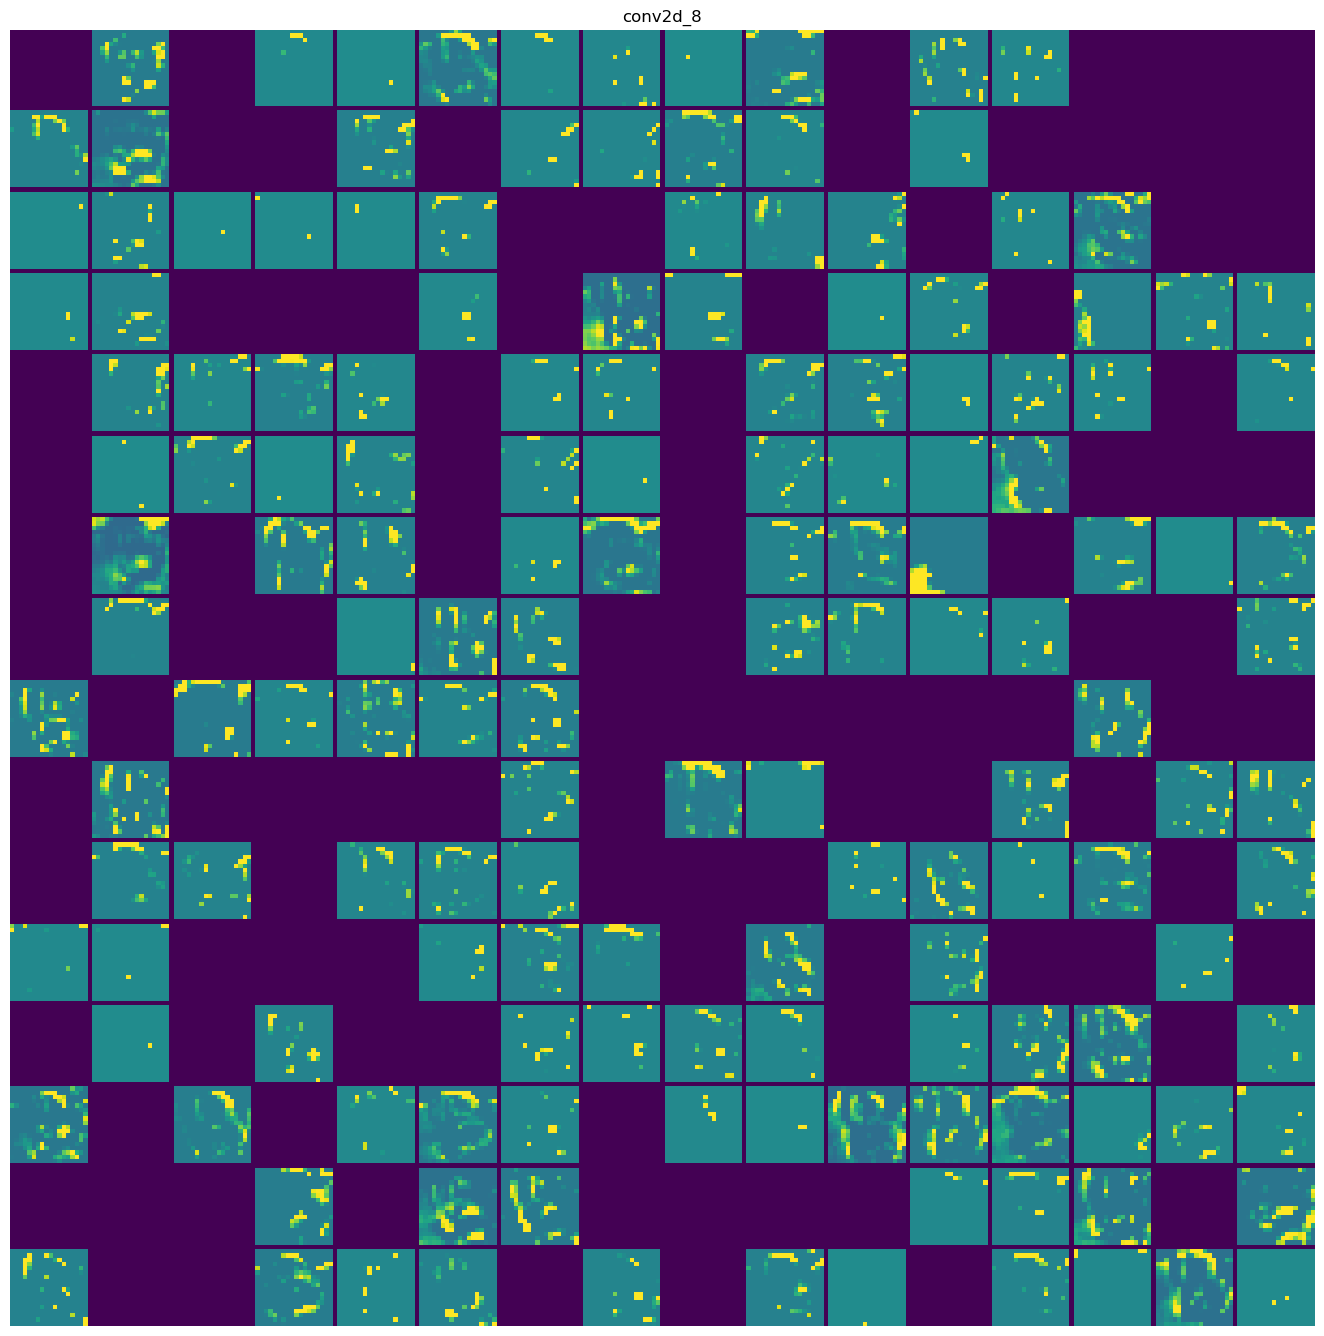

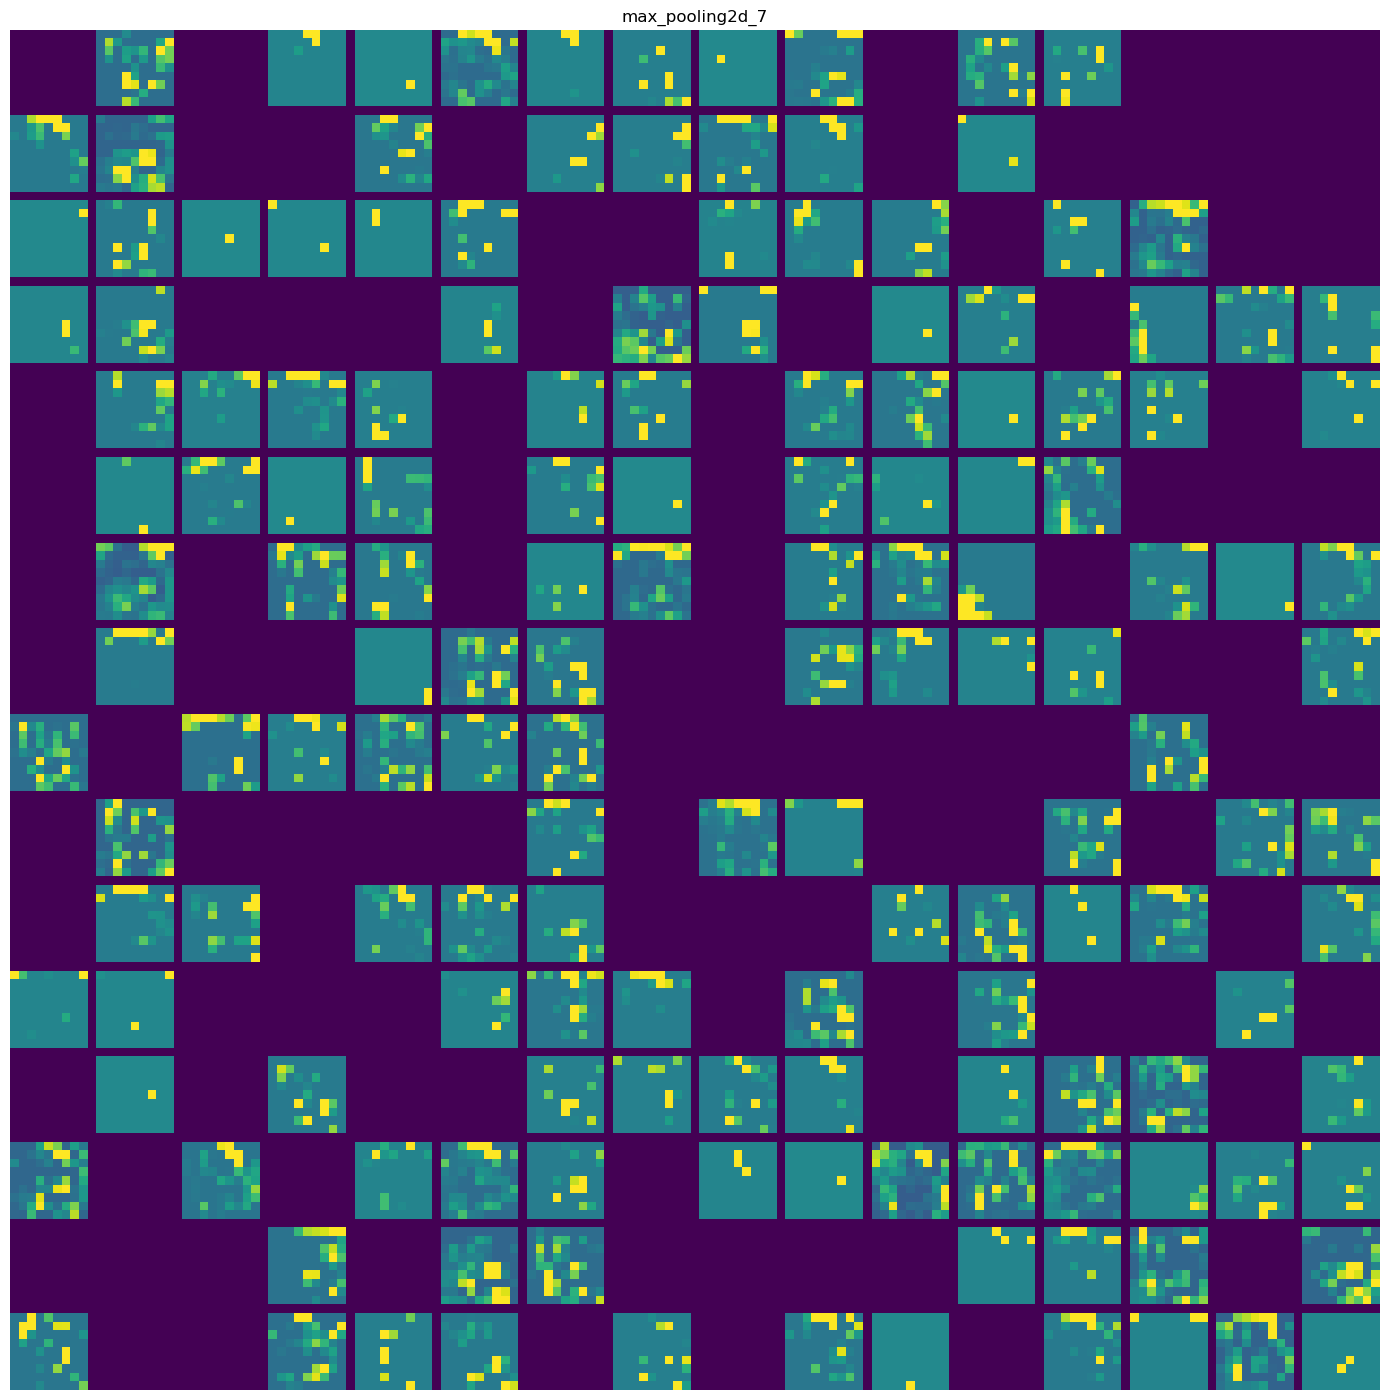

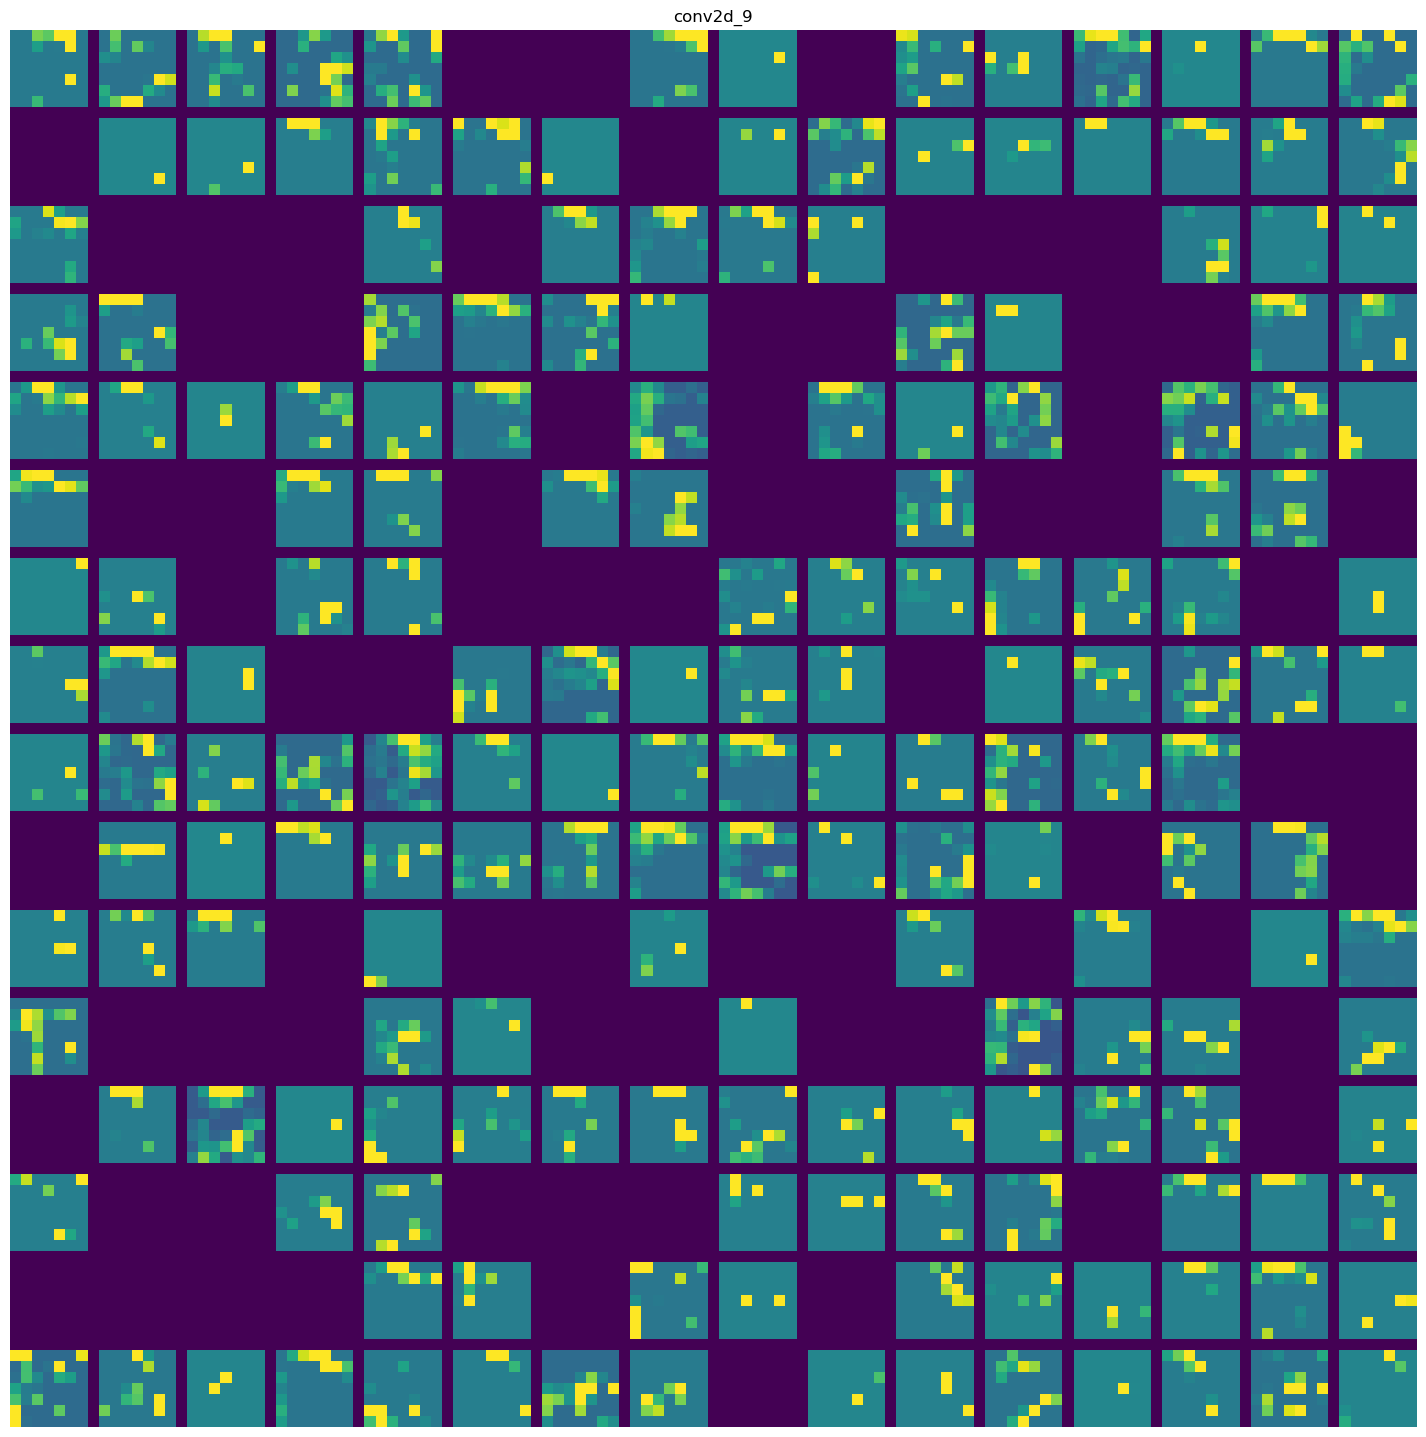

In [64]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

### Visualizing convnet filters

- Another easy way to inspect the filters learned by CNNs is to display the visual pattern that each filter is meant to respond to.
- This can be done with gradient ascent in input space: applying gradient descent to the value of the input image of a CNN so as to maximize the response of a specific filter, starting from a blank input image. The resulting input image will be one that the chosen filter is maximally responsive to.
- Let’s try this with the filters of the Xception model, pretrained on ImageNet. The process is simple: we’ll build a loss function that maximizes the value of a given filter in a given convolution layer, and then we’ll use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. This will be our second example of a low-level gradient descent loop leveraging the GradientTape object

#### Instantiating the Xception convolutional base

In [65]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

#### Printing the names of all convolutional layers in Xception

In [66]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_3
block3_sepconv1
block3_sepconv2
conv2d_4
block4_sepconv1
block4_sepconv2
conv2d_5
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_6
block14_sepconv1
block14_sepconv2


#### Creating a feature extractor model

In [67]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

#### Using the feature extractor

In [68]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [69]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

#### Loss maximization via stochastic gradient ascent

In [70]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

#### Function to generate filter visualizations

In [71]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

#### Utility function to convert a tensor into a valid image

In [72]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

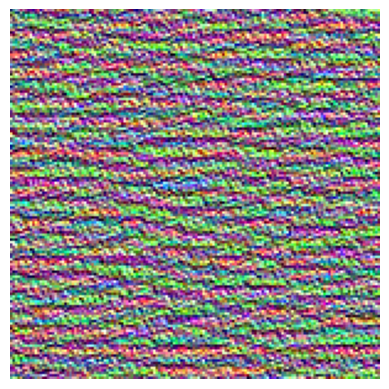

In [73]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

#### Generating a grid of all filter response patterns in a layer

In [74]:
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

### Visualizing heatmaps of class activation

- This general category of techniques is called class activation map (CAM) visualization, and it consists of producing heatmaps of class activation over input images.
- **"Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization.**" Grad-CAM consists of taking the output feature map of a convolution layer, given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel. Intuitively, one way to understand this trick is to imagine that you are weighting a spatial map of "how intensely the input image activates different channels" by "how important each channel is with regard to the class," resulting in a spatial map of "how intensely the input image activates the class."



#### Loading the Xception network with pretrained weights

In [75]:
model = keras.applications.xception.Xception(weights="imagenet")

#### Preprocessing an input image for Xception

In [76]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

In [77]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

1/1 [==============================] - 1s 962ms/step
[('n02504458', 'African_elephant', 0.8699273), ('n01871265', 'tusker', 0.07696834), ('n02504013', 'Indian_elephant', 0.023537153)]


In [78]:
np.argmax(preds[0])

386

#### Setting up a model that returns the last convolutional output

In [79]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

#### Reapplying the classifier on top of the last convolutional output

In [80]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

#### Retrieving the gradients of the top predicted class

In [81]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

#### Gradient pooling and channel-importance weighting

In [82]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

#### Heatmap post-processing

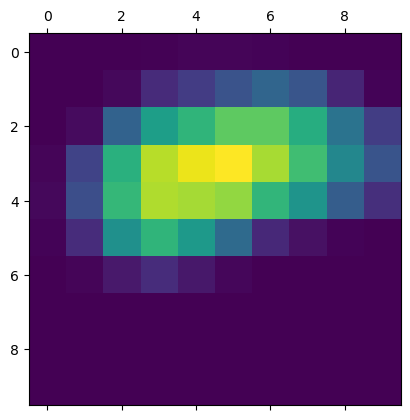

In [83]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

#### Superimposing the heatmap on the original picture

In [84]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


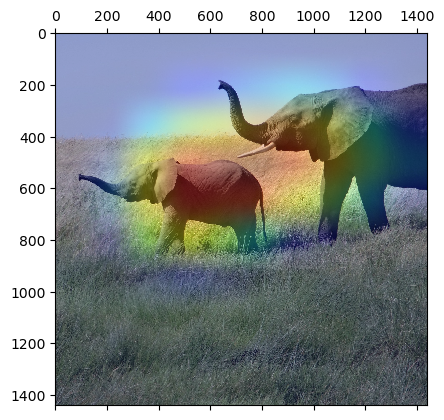

In [85]:
plt.matshow(superimposed_img)

In [86]:
from tensorflow import keras

model_1 = keras.applications.xception.Xception(weights="imagenet")

In [87]:
img_path = keras.utils.get_file(
    fname="elephant",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

In [88]:
preds = model_1.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

1/1 [==============================] - 1s 1s/step
[('n02504458', 'African_elephant', 0.8699273), ('n01871265', 'tusker', 0.07696834), ('n02504013', 'Indian_elephant', 0.023537153)]


1/1 [==============================] - 1s 1s/step
[('n02113023', 'Pembroke', 0.11103284), ('n02113186', 'Cardigan', 0.059298553), ('n02110806', 'basenji', 0.042334836)]


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


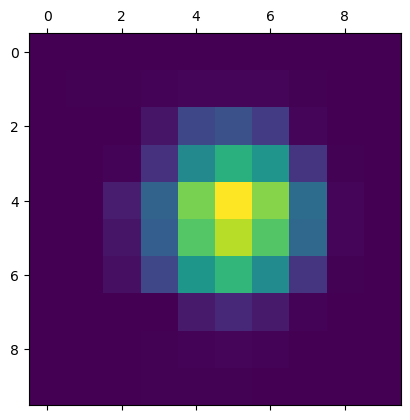

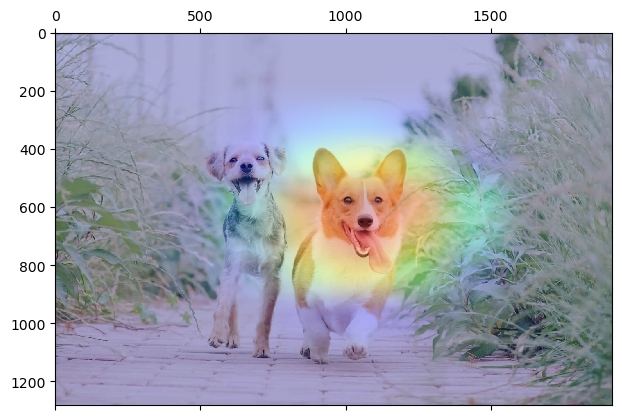

In [89]:
model = keras.applications.xception.Xception(weights="imagenet")

img_path = keras.utils.get_file(
    fname="dog.jpg",
    origin="https://protectmypaws.com/wp-content/uploads/2023/07/happy-dogs.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

np.argmax(preds[0])

last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Save the superimposed image to PDF
plt.savefig("CAM_output.pdf", format="pdf", bbox_inches="tight")

# Display the image (optional)
plt.show()

plt.matshow(superimposed_img)

The first is the heatmap showing the influential regions of the image, and the second is the original image with the heatmap superimposed on it, highlighting the areas that most contributed to the model's prediction.